One potential PROBLEM!!! the share of countries per community is  0:47.8%, 1:30.18%, and 2:22%. Therefore, it might be that group 2 is antifragile on average because it has less number of countries. To make sure that this is result is independent of the share of countries among the communities found, one option could be to randomly generate labels of three catergorical classes to simulate the three communities found and distribute the labels among countries such that we end up with the same share of countries among communities as the CD algorithm computed. In this way, if we repeat the process several times, we could statistically conclude that the community pattern found can not be explained by random labels. 

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [19]:
af_ex_pca = pd.read_csv('af_ex_pca.csv',index_col=0)

In [20]:
pivot_afex=af_ex_pca.pivot_table(values='af_ex_pca',columns='country',index='year')
pivot_afex=pivot_afex.drop(columns='Unspecified Area')

In [21]:
pop=pd.read_csv('pairing_data/Population_clean.csv',index_col=0)
gdp = pd.read_csv('pairing_data/GDP_clean.csv',index_col=0)
distance = pd.read_csv('pairing_data/for_distance_pairing/distances_year_ex_im.csv',index_col=0) # distances in Km
df_communities = pd.read_csv('community_countries.csv',index_col=0)

In [22]:
df_communities['labels'] = np.random.choice([0,1,2],size=210,p=[0.476190,0.371429,0.152381])
mergd_afex_communities = pivot_afex.T.merge(df_communities,on='country')    

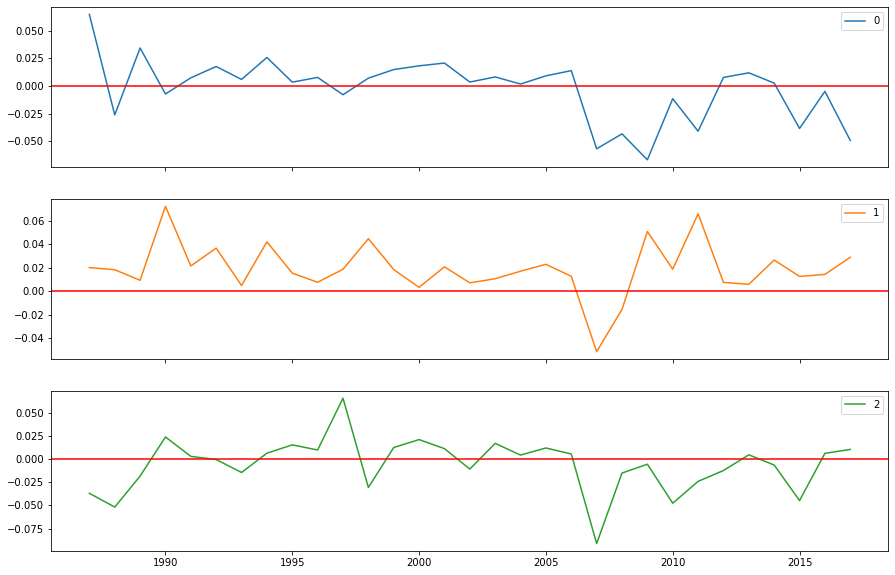

In [23]:
ax=mergd_afex_communities.groupby('labels').median().T.plot(subplots=True,figsize=(15,10))
ax[0].axhline(0,c='red')
ax[1].axhline(0,c='red')
ax[2].axhline(0,c='red')

In [24]:
merged_pop_communities = pop.merge(df_communities,how='inner',left_on='country.value',right_on='country').drop(columns='country.value',axis=1)
merged_gdp_communities = gdp.merge(df_communities,how='inner',left_on='country.value',right_on='country').drop(columns='country.value',axis=1)
merged_pop_communities = merged_pop_communities[['date','value','country','labels']]
merged_gdp_communities = merged_gdp_communities[['date','value','country','labels']]

merged_distances_ex_communities = distance.groupby(['exporter','Year']).sum().reset_index().merge(df_communities,how='inner',left_on='exporter',right_on='country').drop(columns='exporter',axis=1)
merged_distances_in_communities = distance.groupby(['importer','Year']).sum().reset_index().merge(df_communities,how='inner',left_on='importer',right_on='country').drop(columns='importer',axis=1)

Text(0.5, 1.0, 'Population')

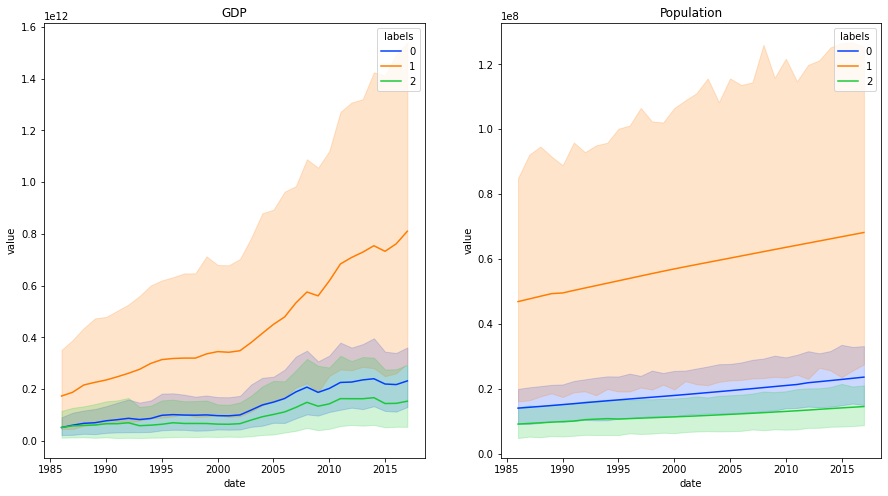

In [25]:
fig,axs=plt.subplots(1,2,figsize=(15,8))
a=sns.lineplot(data=merged_gdp_communities,y='value',x='date',hue='labels',ax=axs[0],palette='bright',hue_order=[0,1,2])
b=sns.lineplot(data=merged_pop_communities[['date','value','country','labels']],y='value',x='date',hue='labels',ax=axs[1],palette='bright',hue_order=[0,1,2])
axs[0].set_title('GDP')
axs[1].set_title('Population')

Text(0.5, 1.0, 'importation distances')

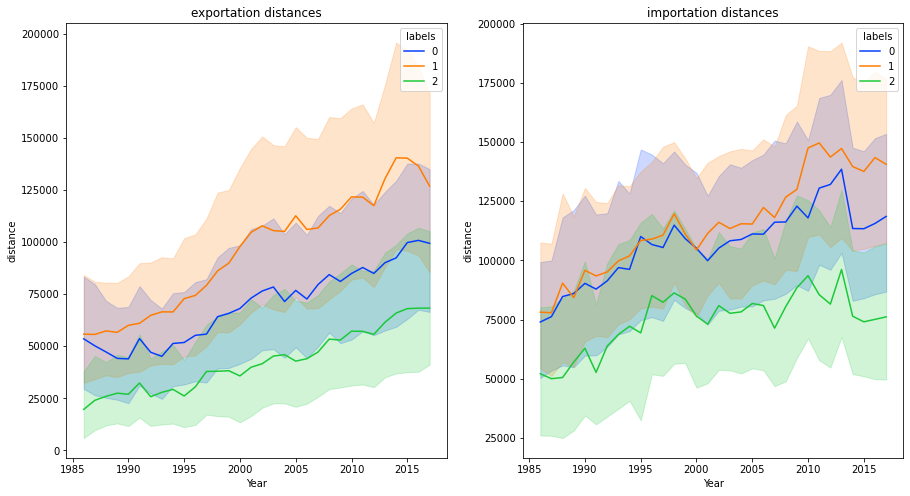

In [26]:
fig,axs=plt.subplots(1,2,figsize=(15,8))
sns.lineplot(data=merged_distances_ex_communities,y='distance',x='Year',hue='labels',palette='bright',hue_order=[0,1,2],ax=axs[0])
sns.lineplot(data=merged_distances_in_communities,y='distance',x='Year',hue='labels',palette='bright',hue_order=[0,1,2],ax=axs[1])
axs[0].set_title('exportation distances')
axs[1].set_title('importation distances')

In [28]:
# fig,axs=plt.subplots(2,2,figsize=(15,8))
# sns.boxplot(data=merged_gdp_communities.groupby(['date','labels']).mean().reset_index().pivot_table(index='date',columns='labels'),ax=axs[0,0])
# sns.boxplot(data=merged_pop_communities.groupby(['date','labels']).mean().reset_index().pivot_table(index='date',columns='labels'),ax=axs[0,1])
# sns.boxplot(data=merged_distances_ex_communities.groupby(['Year','labels']).mean().reset_index().pivot_table(index='Year',columns='labels'),ax=axs[1,0])
# sns.boxplot(data=merged_distances_in_communities.groupby(['Year','labels']).mean().reset_index().pivot_table(index='Year',columns='labels'),ax=axs[1,1])